In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from statsmodels.stats.weightstats import ttest_ind

## Context

In the National Basketball Association (NBA), games are played between Fall and Spring each year, ending with a set of playoff games and a championship.  One "season" of games thus spans two calendar years. For example, the 2019-2020 season began on October 22, 2019 and will end on April 15, 2020. The playoffs will begin on April 18, 2020, and will end with the NBA Finals in June 2020.

Teams in the NBA are organized into two Conferences:  East and West.  From time to time, as teams change locations or new teams are added, the conferences change.

Players join the NBA by being *drafted*, typically when they are 18 years old.

## This dataset

The dataset in this exam contains information about the "Player of the Week", awarded each week to the player(s) who performed the best during that week's games. 

Each observation in this dataset represents an instance of a certain player being awarded Player of the Week.

The variables in this dataset are:

![](../documentation.png)

In [2]:
nba = pd.read_csv('../NBA_player_of_the_week.csv')

# Data Cleaning and Adjusting

## Heights and Weights

Notice that the `Height` variable is sometimes recorded in inches ("5-9"), and sometimes recorded in centimeters ("221cm").  Similarly, the `Weight` variable is in pounds by default, but sometimes appears in kilograms. 

We need to fix these variables to be consistently in inches and in pounds.

In [3]:
def fix_height(height):
    
    if 'cm' in height: #swap cm to inches
        return int(height.replace('cm',''))*0.394
    else: #swap feet-inches to inches
        values = height.split('-')
        return int(values[0])*12+int(values[1])
    
def fix_weight(weight):
    if 'kg' in weight: #swap to pounds
        return int(weight.replace('kg',''))*2.2
    else:
        return int(weight)

In [4]:
nba = nba.assign(
    Height = nba['Height'].apply(fix_height),
    Weight = nba['Weight'].apply(fix_weight)
)

# Player summaries

Number of unique players who have won "Player of the Week" in the timespan covered by this dataset:

In [5]:
len(nba['Player'].unique())

274

The teams that have had a player win the award the most times are:

In [6]:
nba['Team'].value_counts().nlargest(3)

Los Angeles Lakers     71
San Antonio Spurs      61
Cleveland Cavaliers    59
Name: Team, dtype: int64

The players that have won the Player of the Week Award the most times are:

In [7]:
nba['Player'].value_counts().nlargest(3)

LeBron James    61
Kobe Bryant     33
Kevin Durant    26
Name: Player, dtype: int64

# Positions and size

Basketball players play in "guard" positions (PG, SG, G) or "forward" positions (F, C, F-C, FC, G-F, GF, PF, SF).  It is generally expected that forwards are much taller than guards.  We will use the players in this dataset to analyze size differences between these positions.

## Unique players

We need to narrow down the dataset so that each unique player only appears once.  Since heights and weights are sometimes changing over the years, we will use the median measurement for each unique player.

In [8]:
nba.groupby('Player').agg(
    Height=('Height', 'median'),
    Weight=('Weight', 'median'),
    Position=('Position', 'first')
)

,Height,Weight,Position
Player,,,
Aaron McKie,77.0,209.0,G
Adrian Dantley,77.0,208.0,SF
Al Harrington,81.0,245.0,F
Al Horford,82.0,245.0,FC
Al Jefferson,82.0,289.0,FC
...,...,...,...
World B. Free,74.0,185.0,G
Xavier McDaniel,79.0,205.0,PF
Yao Ming,90.0,310.0,C


## Refactoring position variable

We will create a new variable that identifies each player as simply a Guard or a Forward.

In [9]:
conditions = [
    nba['Position'].str.contains('PG|SG|G'),
    nba['Position'].str.contains('F|C|F-C|FC|G-F|GF|PF|SF'),
]

choices = [
    'Guard',
    'Forward'
]

nba = nba.assign(
    Position_GF = np.select(conditions, choices, None)
)

## Comparing Heights

The following plots show the heights and weights of players, separated by position.

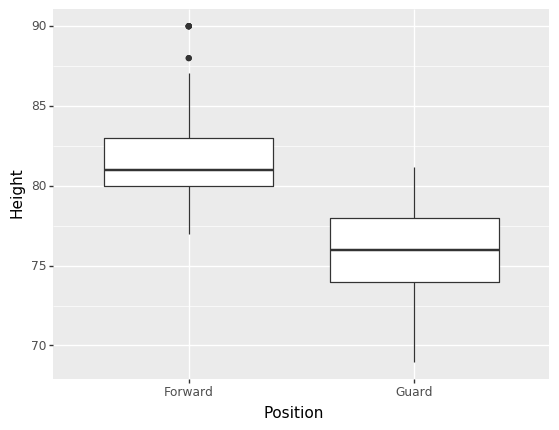

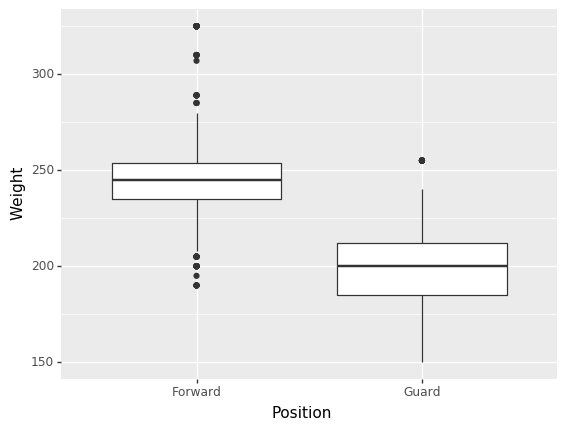

[<ggplot: (8791759784789)>, <ggplot: (8791759784861)>]

In [10]:
heights = (ggplot(nba, aes(x = 'Position_GF', y = 'Height'))
          + geom_boxplot()
          + xlab('Position'))

weights = (ggplot(nba, aes(x = 'Position_GF', y = 'Weight'))
          + geom_boxplot()
          + xlab('Position'))

display([heights, weights])

It is clear from these boxplots that Forwards tend to be taller and weight more than Guards.  

It appears from the plots that the Forwards in the dataset have a mean height of about 81 inches, while Guards have a mean height of 75.3 inches. Forwards have a mean weight of about 245 pounds, while Guards have a mean weight of 200 pounds.

# Different Guard positions

Among the Guard positions, there are two specialties:  Point Guard (PG) and Shooting Guard (SG).  We are interested in studying whether these positions also have a height difference.

The sample mean for each position is given below.

In [11]:
nba[(nba['Position'] == 'PG') | (nba['Position'] == 'SG')].groupby('Position').agg(
    Height=('Height', 'mean')
)

,Height
Position,
PG,74.227924
SG,77.498710


We will conduct a t-test at the 0.05 level.

In [12]:
my_test = ttest_ind(
    x1 = nba[(nba['Position'] == 'PG')]['Height'],
    x2 = nba[(nba['Position'] == 'SG')]['Height'],
    alternative = 'two-sided'
)
t_stat = my_test[0]
p_value = my_test[1]
deg_free = my_test[2]
print("We obtain a t statistic of {t_stat}. This yields a p-value of {p_value}.".format(t_stat = deg_free, p_value = p_value))

We obtain a t statistic of 299.0. This yields a p-value of 6.535231165344249e-32.


We fail to reject the null hypothesis, and find that there is no detectable height difference between Point Guards and Shooting Guards.